In [3]:
# import the required packages

import pandas as pd
import os
import io
import numpy as np
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from osgeo import gdal, osr

In [7]:
# the MNDWI index is used for surface water mapping
# read any green band (having range 0.533–0.590 μm) and SWIR band (having range 1.566–1.651 μm) to extract water information
# MNDWI = Green - SWIR / Green + SWIR

def createRgbTiff(newRasterFilePath,rasterOrigin,pixelWidth, pixelHeight, array, proj,format='GTiff'):
    bands = None
    rows = None
    cols = None
    try:
        bands = array.shape[0]
        rows = array.shape[1]
        cols = array.shape[2]
    except:
        bands = 1
        rows = array.shape[0]
        cols = array.shape[1]
        
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName(format)
    # assign bands to the raster
    options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
    outRaster = driver.Create(newRasterFilePath, cols, rows, bands, gdal.GDT_UInt16, options=options)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    if(bands==1):
        outRaster.GetRasterBand(1).WriteArray(array)
    else:
        for band in range(bands):
            outRaster.GetRasterBand(band+1).WriteArray( array[band, :, :] )

    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(proj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())

    outRaster.FlushCache()
    print('Geotiff image is created successfully')

if __name__ == "__main__":
     
    #input folder location to tif files    
    path = r'C:\Pixxel_data\EO1H1480472016328110PZ_1GST\EO1H1480472016328110PZ'
     #list all the available tiffs in the folder
    tiffs = glob.glob(os.path.join(path,"*.tif*")) 

    #extract transformation and crs info
    transforms = gdal.Open(tiffs[0]).GetGeoTransform()
    rasterOrigin = [transforms[0],transforms[3]]
    pixelWidth = transforms[1]
    pixelHeight = transforms[5]
    proj = int(osr.SpatialReference(wkt=gdal.Open(tiffs[0]).GetProjection()).GetAttrValue('AUTHORITY',1))
    print("CRS EPSG Code: ", proj)
    #read the green band
    grArr = gdal.Open(tiffs[18]).ReadAsArray()
    #read the SWIR band
    swir1 = gdal.Open(tiffs[142]).ReadAsArray()
    diff = (grArr - swir1)
    sum = (grArr + swir1)
    sum[sum==0] = 1
    mndwi = diff/sum
    print(np.amax(diff))
    print(np.amin(diff))
    print(np.amax(sum))
    print(np.amin(sum))
    sampleOutputPath = r'C:\Users\rohan\Downloads\mndwi_test.tif'
    createRgbTiff(sampleOutputPath,rasterOrigin,pixelWidth, pixelHeight, mndwi, proj,format='GTiff')

CRS EPSG Code:  32643
3718
-1771
6124
1
Geotiff image is created successfully


(3554101, 1)
Geotiff image is created successfully


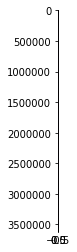

In [8]:
# read the SWIR band and apply kmeans algorithm, by dividing in 5 clusters

#sampleInputPath = r'C:\Pixxel_data\EO1H1480472016328110PZ_1GST\EO1H1480472016328110PZ\EO1H1480472016328110PZ_B008_L1GST.TIF'
#array = gdal.Open(sampleInputPath).ReadAsArray()
#print(array.shape)

pixel_values = swir1.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
# apply kmeans algorithm and no of clusters = 5
kmeans = KMeans(n_clusters=5, random_state=0).fit(pixel_values)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
plt.imshow(pic2show)
print(pic2show.shape)
picOut = pic2show.reshape(3481, 1021)
sampleOutputPath = r'C:\Users\rohan\Downloads\test_cluster_out4.tif'
createRgbTiff(sampleOutputPath,rasterOrigin,pixelWidth, pixelHeight, picOut, proj,format='GTiff')

In [9]:
# to analyse and verify the output, we can extract any of the label from the kmeans algorithm, and then by applying mask, we are
# able to extract the water bodies. If we further perform combinations of better stacking of green and SWIR bands, we will get
# better quality of output. This is for POC purpose.


pic2show1 = kmeans.cluster_centers_[kmeans.labels_]
print(np.amin(pic2show1[(kmeans.labels_==0)]), np.amax(pic2show1[(kmeans.labels_==0)]))
a = (pic2show1 >(np.amin(pic2show1[(kmeans.labels_==0)])-1))
b = (pic2show1 <(np.amax(pic2show1[(kmeans.labels_==0)])+1))
c = (a & b)
e = pic2show1[~c]
pic2show1[~c] = 0
pic2show1[c] = 1
print(np.amin(pic2show1), np.amax(pic2show1))
picOut1 = pic2show1.reshape(3481, 1021)
sampleOutputPath = r'C:\Users\rohan\Downloads\test_cluster_out_mask3.tif'
createRgbTiff(sampleOutputPath,rasterOrigin,pixelWidth, pixelHeight, picOut1, proj,format='GTiff')

3.6892052 3.6892052
0.0 1.0
Geotiff image is created successfully
